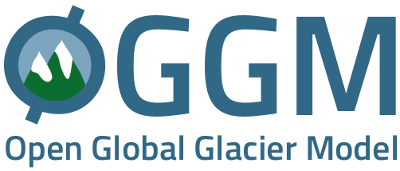

# Getting started with flowline models: Ice flow parameters

In this notebook we will play around with ice flow parameters. If you are not yet familiar with the relations of glacier flow, I recommand to go through these two pages: [1](http://www.antarcticglaciers.org/glacier-processes/glacier-flow-2/glacier-flow/), [2](http://www.antarcticglaciers.org/glacier-processes/glacier-flow-2/glacier-flow-ii-stress-and-strain/).

First, we have to import all needed modules.

In [1]:
# The commands below are just importing the necessary modules and functions
# Plot defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size
# Scientific packages
import numpy as np

# Constants
from oggm import cfg
cfg.initialize()
# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel, RectangularBedFlowline, TrapezoidalBedFlowline, ParabolicBedFlowline
# There are several solvers in OGGM core. We use the default one for this experiment
FlowlineModel = FluxBasedModel


import hide_functions as hf

2018-12-30 11:31:34: oggm.cfg: Using configuration file: /home/zora/Dokumente/git/oggm/oggm/params.cfg


## Glen's creep parameter

The ice flow parameters, see the [documentation](https://docs.oggm.org/en/latest/ice-dynamics.html?highlight=oerleman#ice-flow ), are going to have a strong influence on the behavior of the glacier. The default in OGGM is to set [Glen's creep parameter A](http://www.antarcticglaciers.org/modern-glaciers/glacier-flow-2/glacier-flow-ii-stress-and-strain/) to the "standard value" defined by Cuffey and Patterson:

In [2]:
# Default in OGGM
A = cfg.PARAMS['glen_a']
print(A)

2.4e-24


This parameter relates the shear stress to the rate of deformation and is assumed to be constant. It depends on crystal size and fabric, concentration and type of impurities, and ice temperature¹. We can change it and see what happens.

Therefore we have to define the bed and a grid. (We will do similiar steps like in [flowline_model](http://edu.oggm.org/en/latest/notebooks_flowline_intro.html#glacier-flowline-modelling) to generate a set-up for our experiment.)

In [3]:
# This is the bed rock, linearily decreasing from 3400 m altitude to 1400 m, in 200 steps
nx = 200
bed_h = np.linspace(3400, 1400, nx)
# At the beginning, there is no glacier so our glacier surface is at the bed altitude
surface_h = bed_h
# Let's set the model grid spacing to 100 m 
map_dx = 100
# Calculate the corresponding distance along the glacier (from the top)
distance_along_glacier = np.linspace(0, nx, nx) * 0.1 # in km 

Define the equilibrium line altitude (ELA):

In [4]:
# ELA at 3000m a.s.l., gradient 4 mm m-1
mb_model = LinearMassBalance(3000, grad=4)

In [5]:
# The units of widths is in "grid points", i.e. 3 grid points = 300 m in our case
widths = np.zeros(nx) + 3.
# Define our bed
init_flowline = RectangularBedFlowline(surface_h=surface_h, bed_h=bed_h, widths=widths, map_dx=map_dx)

Now we can calculate a the behavior of the glacier with the default parameter:

In [6]:
# Define how long the model should run
years = 600
# and Glen's parameter A
A = cfg.PARAMS['glen_a']

In [7]:
# Initialize the model with the following function and save the output as simple_glacier_h
model = hf.init_model(init_flowline, mb_model, years, A)
simple_glacier_h = model.fls[-1].surface_h

Let's make A 10 times smaller and 10 times larger:

In [8]:
# Glen's parameter A
A_small = cfg.PARAMS['glen_a'] / 10
A_large = cfg.PARAMS['glen_a'] * 10

In [9]:
# Reinitialize the model with the new parameter and save the output as stiffer_glacier_h
model = hf.init_model(init_flowline, mb_model, years, A_small)
stiffer_glacier_h = model.fls[-1].surface_h
# And again (save the output as softer_glacier_h)
model = hf.init_model(init_flowline, mb_model, years, A_large)
softer_glacier_h = model.fls[-1].surface_h

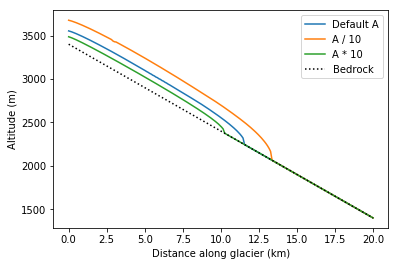

In [10]:
# Plot final results
plt.plot(distance_along_glacier, simple_glacier_h, label='Default A')
plt.plot(distance_along_glacier, stiffer_glacier_h, label='A / 10')
plt.plot(distance_along_glacier, softer_glacier_h, label='A * 10')
# Add the bedrock and lables
hf.plot_xz_bed(distance_along_glacier, bed_h)

In [11]:
# What do the three graphs show you?
# ...

Maybe you see irregularities visible for the orange line (A/10) at around 3-4 km? These can occur due to numerical inaccuracies.

Now it's your turn: if you want you can change the parameters in the way you wish it. For this purpose you can insert new cells (press `[b]` when you are in command mode) or copy cells from above.

## Sliding  parameter

In his [seminal paper](https://www.igsoc.org/annals/24/igs_annals_vol24_year1997_pg382-389.pdf), Hans Oerlemans also uses a so-called "sliding parameter" (here: fs), representing basal sliding. In OGGM this parameter is set to 0 per default, but it can be modified at wish:

In [15]:
# Change sliding to use Oerlemans value:
model = FlowlineModel(init_flowline, mb_model=mb_model, y0=0., glen_a=A, fs=5.7e-20)
# Array to fill with data
nsteps = len(yrs)
length_s3 = np.zeros(nsteps)
vol_s3 = np.zeros(nsteps)
# Loop
for i, yr in enumerate(yrs):
    model.run_until(yr)
    length_s3[i] = model.length_m
    vol_s3[i] = model.volume_km3
# I store the final results for later use
sliding_glacier_h = model.fls[-1].surface_h

TypeError: object of type 'int' has no len()

NameError: name 'sliding_glacier_h' is not defined

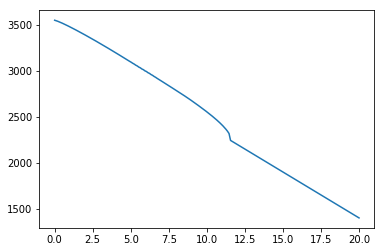

In [13]:
# Plot final result
plt.plot(distance_along_glacier, simple_glacier_h, label='Default')
plt.plot(distance_along_glacier, sliding_glacier_h, label='Sliding glacier')
# Add the bedrock:
plt.plot(distance_along_glacier, init_flowline.bed_h, color='k', label='Bedrock', linestyle=':')
plt.xlabel('Distance along glacier (km)')
plt.ylabel('Altitude (m)')
plt.legend(loc='best');

¹ Oerlemans, J. (2001). *Glaciers and climate change.* CRC Press.

(page 59)